In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, MaxPool2D 
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random, glob
import os, sys, csv, shutil
import cv2
import time, datetime
sys.path.append('/content/sample_data')

In [ ]:
%rm -rf "/content/sample_data/images"
%rm -rf "/content/sample_data/utils.py"

In [ ]:
!apt-get install rar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  rar
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 295 kB of archives.
After this operation, 799 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 rar amd64 2:5.5.0-1 [295 kB]
Fetched 295 kB in 2s (195 kB/s)
Selecting previously unselected package rar.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../rar_2%3a5.5.0-1_amd64.deb ...
Unpacking rar (2:5.5.0-1) ...
Setting up rar (2:5.5.0-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
!unrar x "/content/sample_data/data.rar" "/content/sample_data/"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/sample_data/data.rar

Creating    /content/sample_data/images                               OK
Creating    /content/sample_data/images/train                         OK
Creating    /content/sample_data/images/train/Corrosion_Images        OK
Extracting  /content/sample_data/images/train/Corrosion_Images/1174-c-1000x550.jpg       0%  OK 
Extracting  /content/sample_data/images/train/Corrosion_Images/2.jpg       1%  OK 
Extracting  /content/sample_data/images/train/Corrosion_Images/23065.jpg       1%  OK 
Extracting  /content/sample_data/images/train/Corrosion_Images/3.jpg       3%  OK 
Extracting  /content/sample_data/images/train/Corrosion_Images/4.jpg       3%  OK 
Extracting  /content/sample_data/images/train/Corrosion_Images/48251d2534424ddc8c3a8ec9ebc0a8c7.png       4%  OK 
Extracting  /content/sample_data/images/train/Corrosion_Images/5

In [ ]:
import utils
num_epochs = 20
mode = 'train'
dataset = 'images'
BATCH_SIZE = 10
WIDTH = 224
HEIGHT = 224
model = 'VGG16'
FC_LAYERS = [1024, 1024]
TRAIN_DIR = "/content/sample_data/" + dataset + "/train/"
VAL_DIR = "/content/sample_data/" + dataset + "/val/"

#data augmentation
v_flip = True
h_flip = True
rotation = 90
zoom = 0
shear = 0

In [ ]:
import shutil
import os
traindirfile = "/content/sample_data/" + dataset +"/train/.ipynb_checkpoints"
valdirfile = "/content/sample_data/" + dataset +"/val/.ipynb_checkpoints"

if os.path.exists(traindirfile):
  shutil.rmtree(traindirfile)
else:
  print("The folder does not exist")
 
if os.path.exists(valdirfile):
  shutil.rmtree(valdirfile)
else:
  print("The folder does not exist")

The folder does not exist
The folder does not exist


In [ ]:
preprocessing_function = None
base_model = None

from tensorflow.keras.applications.vgg16 import preprocess_input
preprocessing_function = preprocess_input
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, 3))

58892288/58889256 [==============================] - 2s 0us/step


In [ ]:
print("\n***** Begin training *****")
print("Dataset -->", dataset)
print("Model -->", model)
print("Resize Height -->", HEIGHT)
print("Resize Width -->", WIDTH)
print("Num Epochs -->", num_epochs)
print("Batch Size -->", BATCH_SIZE)

# Create directories if needed
if not os.path.isdir("/content/sample_data/checkpoints"):
    os.makedirs("/content/sample_data/checkpoints")

# Prepare data generators
train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocessing_function,
      rotation_range=rotation,
      shear_range=shear,
      zoom_range=zoom,
      horizontal_flip=h_flip,
      vertical_flip=v_flip
    )
val_datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)
train_generator = train_datagen.flow_from_directory(TRAIN_DIR, target_size=(HEIGHT, WIDTH), batch_size=BATCH_SIZE)
validation_generator = val_datagen.flow_from_directory(VAL_DIR, target_size=(HEIGHT, WIDTH), batch_size=BATCH_SIZE)

# Save the list of classes for prediction mode later
class_list = utils.get_subfolders(TRAIN_DIR)

finetune_model = utils.build_finetune_model(base_model, dropout=1e-3, fc_layers=FC_LAYERS, num_classes=len(class_list))

adam = Adam(lr=0.00001)
finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

num_train_images = utils.get_num_files(TRAIN_DIR)
num_val_images = utils.get_num_files(VAL_DIR)

def lr_decay(epoch):
  if epoch%20 == 0 and epoch!=0:
    lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, lr/2)
    print("LR changed to {}".format(lr/2))
  return K.get_value(model.optimizer.lr)

learning_rate_schedule = LearningRateScheduler(lr_decay)

filepath="/content/sample_data/checkpoints/" + model + "_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

finetune_model.summary()

history = finetune_model.fit_generator(train_generator, epochs=num_epochs, workers=8, steps_per_epoch=num_train_images // BATCH_SIZE, 
    validation_data=validation_generator, validation_steps=num_val_images // BATCH_SIZE, shuffle=True, callbacks=callbacks_list)



***** Begin training *****
Dataset --> images
Model --> VGG16
Resize Height --> 224
Resize Width --> 224
Num Epochs --> 20
Batch Size --> 10
Found 153 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Model: "functional_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
____________________________

In [ ]:
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure()

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')
    plt.show()

    
    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.show()

    plt.savefig('acc_vs_epochs.png')

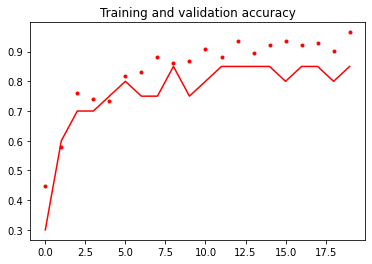

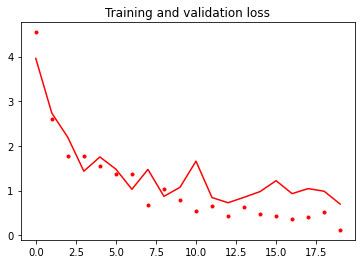

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_training(history)

In [ ]:
valdirfile = "/content/sample_data/" + dataset +"/val/.ipynb_checkpoints"
folder = ['corrosion','leak','normal']

if os.path.exists(valdirfile):
  shutil.rmtree(valdirfile)
else:
  print("The folder does not exist")

src = "/content/sample_data/" + dataset +"/val"

for i in folder:
  fol = os.path.join(src, i)
  if os.path.exists(os.path.join(fol, '.ipynb_checkpoints')):
    shutil.rmtree(os.path.join(fol, '.ipynb_checkpoints'))
  else:
    print("The folder does not exist")

The folder does not exist
The folder does not exist
The folder does not exist
The folder does not exist


Actual class =  Corrosion_Images ----Predicted class =  Corrosion_Images Confidence =  0.8074364


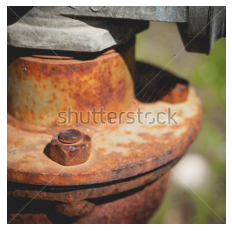

Actual class =  Corrosion_Images ----Predicted class =  Normal_Condition Confidence =  0.9879974


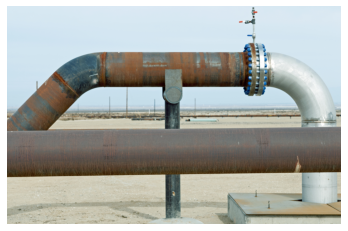

Actual class =  Corrosion_Images ----Predicted class =  Leak_Images Confidence =  0.5770062


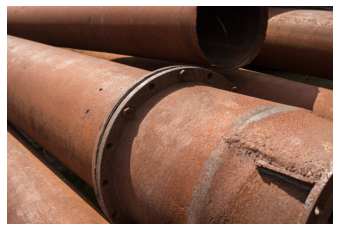

Actual class =  Corrosion_Images ----Predicted class =  Corrosion_Images Confidence =  0.9999988


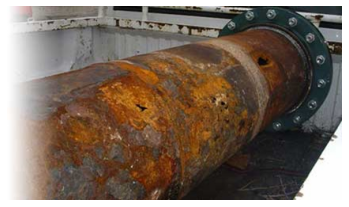

Actual class =  Corrosion_Images ----Predicted class =  Corrosion_Images Confidence =  0.9935929


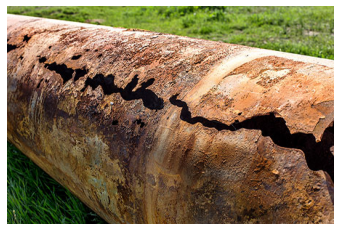

Actual class =  Normal_Condition ----Predicted class =  Normal_Condition Confidence =  1.0


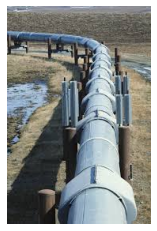

Actual class =  Normal_Condition ----Predicted class =  Normal_Condition Confidence =  0.99996495


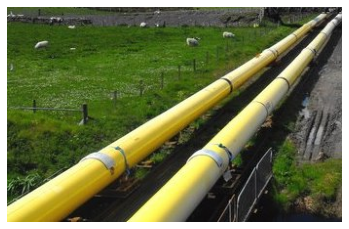

Actual class =  Normal_Condition ----Predicted class =  Normal_Condition Confidence =  0.9494921


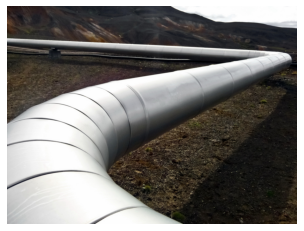

Actual class =  Normal_Condition ----Predicted class =  Normal_Condition Confidence =  1.0


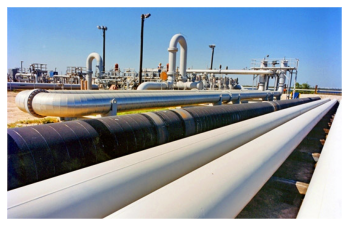

Actual class =  Normal_Condition ----Predicted class =  Normal_Condition Confidence =  1.0


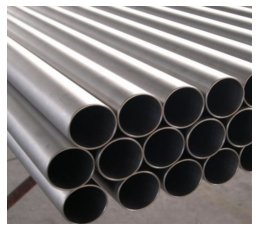

Actual class =  Normal_Condition ----Predicted class =  Normal_Condition Confidence =  1.0


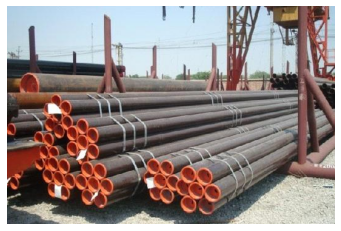

Actual class =  Normal_Condition ----Predicted class =  Normal_Condition Confidence =  1.0


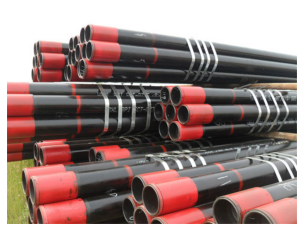

Actual class =  Normal_Condition ----Predicted class =  Normal_Condition Confidence =  1.0


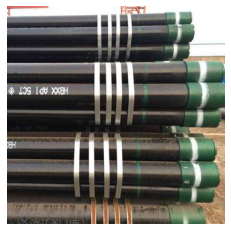

Actual class =  Normal_Condition ----Predicted class =  Normal_Condition Confidence =  1.0


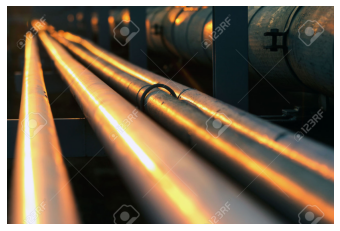

Actual class =  Normal_Condition ----Predicted class =  Corrosion_Images Confidence =  0.70948774


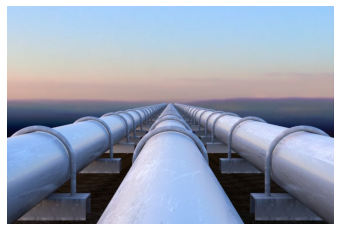

Actual class =  Leak_Images ----Predicted class =  Leak_Images Confidence =  0.99967813


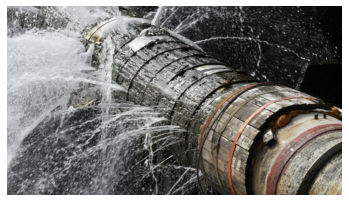

Actual class =  Leak_Images ----Predicted class =  Normal_Condition Confidence =  0.9933188


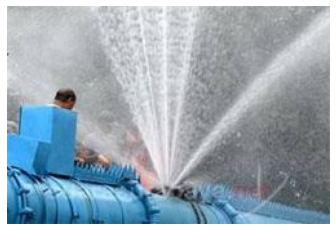

Actual class =  Leak_Images ----Predicted class =  Leak_Images Confidence =  0.9855203


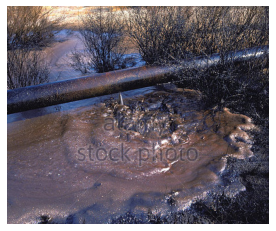

Actual class =  Leak_Images ----Predicted class =  Leak_Images Confidence =  0.9736085


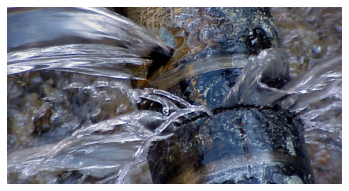

Actual class =  Leak_Images ----Predicted class =  Leak_Images Confidence =  0.9909464


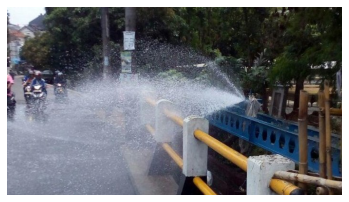

In [ ]:
gt = os.listdir(src)
for label in gt :
  list_file = os.listdir(os.path.join(src, label))
  dir = os.path.join(os.path.join(src, label))
  for file in list_file:
    dir = os.path.join(os.path.join(src, label))
    image = cv2.imread(os.path.join(dir,file),-1)
    save_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.float32(cv2.resize(image, (HEIGHT, WIDTH)))
    image = preprocessing_function(image.reshape(1, HEIGHT, WIDTH, 3))
    finetune_model = utils.build_finetune_model(base_model, 1e-3,FC_LAYERS, len(class_list))
    finetune_model.load_weights("/content/sample_data/checkpoints/" + model + "_model_weights.h5")
    out = finetune_model.predict(image)
    confidence = out[0]
    class_prediction = list(out[0]).index(max(out[0]))
    class_name = class_list[class_prediction]
    print("Actual class = ", label, "----Predicted class = ", class_name, "Confidence = ", confidence[class_prediction])
    plt.imshow(save_image)
    plt.axis('off')
    plt.show()

In [ ]:
model2 = Sequential()
model2.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model2.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model2.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model2.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model2.add(Flatten())
model2.add(Dense(units=104,activation="relu"))
model2.add(Dropout(1e-3))
model2.add(Dense(units=104,activation="relu"))
model2.add(Dropout(1e-3))
model2.add(Dense(units=3, activation="softmax"))
model2.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

history = model2.fit_generator(train_generator, epochs=num_epochs*5, workers=8, steps_per_epoch=num_train_images // BATCH_SIZE, 
    validation_data=validation_generator, validation_steps=num_val_images // BATCH_SIZE, shuffle=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 56, 56, 256)      